In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram,cophenet,linkage
from scipy.spatial.distance import pdist

In [8]:
data1 = pd.read_excel('/content/drive/MyDrive/CAPSTONE/CAPSTONE_PROJECT/0_dataset/2_CLEANED DATASET/FULLY_CLEANED DATASET.xlsx')

In [9]:
df=data1.copy()
df.columns

Index(['Unnamed: 0', 'Report Number', 'Local Case Number', 'Agency Name',
       'ACRS Report Type', 'Crash Date/Time', 'Route Type', 'Road Name',
       'Cross-Street Name', 'Collision Type', 'Weather', 'Surface Condition',
       'Light', 'Traffic Control', 'Driver Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Latitude', 'Longitude', 'Vehicle Model', 'Circumstance_Category',
       'hour', 'Crash_year', 'Crash_month', 'Crash_day', 'Crash_hour',
       'Crash_day_name', 'Crash_date', 'Crash_week'],
      dtype='object')

In [5]:
features = ['Latitude','Longitude','Speed Limit','hour','Crash_day']
X = df[features]

In [6]:
X.head(3)

,Latitude,Longitude,Speed Limit,hour,Crash_day
0,39.219796,-77.257416,40.0,17,21
1,39.180181,-77.250657,55.0,10,22
2,39.121219,-76.988905,40.0,11,25


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.head()

,Latitude,Longitude,Speed Limit,hour,Crash_day
0,1.933065,-1.536521,0.698377,0.690858,0.604927
1,1.373499,-1.465167,2.055522,-0.639643,0.718964
2,0.540661,1.298025,0.698377,-0.449571,1.061076
3,1.765469,-0.312631,-0.206385,-0.639643,0.718964
4,-0.611327,0.576662,-2.694483,0.120643,-1.447744


## 3. KMeans – Try different k values + compute silhouette + elbow

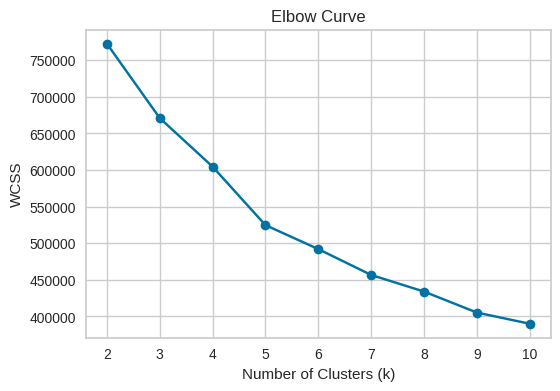

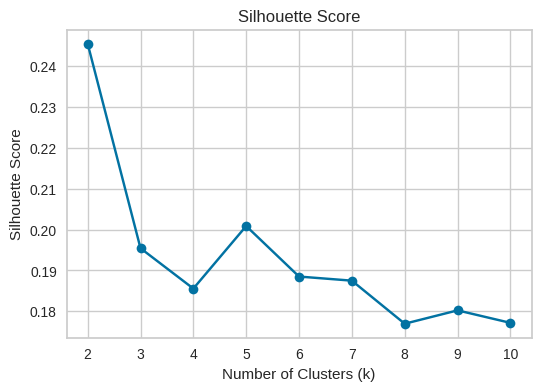

In [9]:
wcss = []
sil_score = []
k_range = range(2, 11)

for i in k_range:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    labels = km.labels_
    sil_score.append(silhouette_score(X_scaled, labels))

# ------------------------
# Elbow Plot
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# ------------------------
# Silhouette Score Plot
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(k_range, sil_score, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


| Method            | Observation                                      | Conclusion                  |
|-------------------|--------------------------------------------------|------------------------------|
| Elbow Method      | Sharp drop until k=5, then curve flattens       | k=5 is optimal elbow point  |
| Silhouette Score  | k=2 highest but not useful (too broad clusters) | k=5 gives balanced separation |
| Hotspot Logic     | More clusters = clearer hotspot regions         | k=5 gives meaningful hotspots |

**Final Choice: k = 5 (Best balance of quality + hotspot usefulness)**


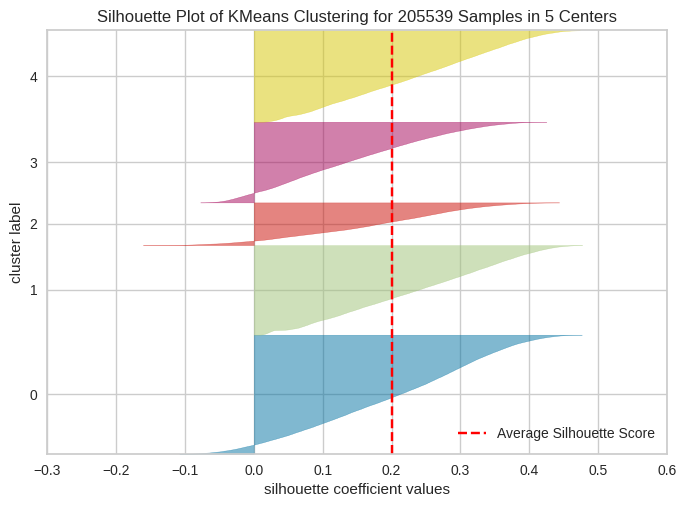

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 205539 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

# Final chosen k
k = 5

# Train the model
model = KMeans(n_clusters=k, random_state=42)
model.fit(X_scaled)

# Silhouette Visualizer
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()


### The silhouette plot for k = 5 shows that all clusters have mostly positive silhouette values, indicating good cluster cohesion and separation. The average silhouette score (~0.20) is acceptable for geospatial crash data. No cluster shows strong negative values, meaning there is minimal overlap. Overall, k = 5 provides meaningful and interpretable hotspot clusters.


## 4. Train final KMeans model

In [11]:
# -----------------------------------------------
# 3. Train final KMeans model (k = 5)
# -----------------------------------------------
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# -----------------------------------------------
# 4. Add cluster labels back to dataframe
# -----------------------------------------------
df['kmeans_cluster'] = kmeans.labels_

# View results
df.head()


,Unnamed: 0,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Collision Type,...,Circumstance_Category,hour,Crash_year,Crash_month,Crash_day,Crash_hour,Crash_day_name,Crash_date,Crash_week,kmeans_cluster
0,0,MCP3126006X,250037402,Montgomery_County_Police,Injury Crash,2025-08-21 17:21:00,Maryland_State_Route,FREDERICK RD,TILTON DR,Rear-End (Same Direction),...,Tailgating,17,2025,8,21,17,Thursday,2025-08-21,34,0
1,1,MCP2349001B,250037516,Montgomery_County_Police,Property Damage Crash,2025-08-22 10:44:00,Interstate_Route,EISENHOWER MEMORIAL HWY,DIAMONDBACK DR,Single Vehicle,...,Lane Violation,10,2025,8,22,10,Friday,2025-08-22,34,0
2,2,MCP296500BC,250033157,Montgomery_County_Police,Property Damage Crash,2025-07-25 11:55:00,Bicycle_Route,AIRPARK RD,NEW HAMPSHIRE AVE (SB/L) NORBECK RD (WB/L) SPE...,Sideswipe (Same Direction),...,Lane Violation,11,2025,7,25,11,Friday,2025-07-25,30,1
3,3,MCP2159003K,250037509,Montgomery_County_Police,Property Damage Crash,2025-08-22 10:36:00,Maryland_State_Route,CLOPPER RD,SPUR TO SHADY GROVE RD,Rear-End (Same Direction),...,Tailgating,10,2025,8,22,10,Friday,2025-08-22,34,0
4,4,MCP312900D6,250034573,Montgomery_County_Police,Property Damage Crash,2025-08-03 14:10:00,Maryland_State_Route,E RANDOLPH RD,BRIARDALE RD,Rear vs Side,...,Backing Error,14,2025,8,3,14,Sunday,2025-08-03,31,2


# Find optimal clusters for Agglomerative.

### Why Agglomerative Fails on Full Data
Agglomerative clustering cannot run on 200k rows because it requires computing a full distance matrix.  
This grows quadratically (O(n²)), quickly exceeding memory limits and causing system crashes.

### Why Sampling Still Works
A small random sample (2k–5k rows) keeps the overall data structure.  
It is enough to analyze linkage behavior, dendrogram patterns, and silhouette trends.

### How Sampling Helps Decide Optimal Clusters
Using the sample, we can estimate the best linkage method and number of clusters.  
Then, the chosen n_clusters can be applied to the full dataset using a scalable algorithm like KMeans.


* Agglomerative clustering cannot be applied to the full dataset because the
algorithm computes a complete distance matrix with O(n²) complexity.

* With 200,000 records, this becomes computationally impossible for Google Colab
or any standard machine.

* Therefore, Agglomerative is used only on a small
sample for structural analysis, while KMeans is applied to the full dataset
for scalable clustering.


### Final Clustering Algorithm Comparison

| Algorithm       | Full Dataset (200k rows)       | Sample Data (2k–10k rows) | Recommended Use            |
|-----------------|--------------------------------|-----------------------------|-----------------------------|
| **KMeans**      | Yes (fast, scalable)           | Yes                         | Best for full clustering   |
| **Agglomerative** | No (memory crash, O(n²))      | Yes                         | Structure analysis only    |
| **DBSCAN**      | No (too slow, O(n²))           | Yes                         | Best for density hotspots  |

**Conclusion:**  
Use **KMeans** for final clustering on the full dataset.  
Use **Agglomerative** and **DBSCAN** only on sampled data to understand structure and hotspots.


# **FINAL ANALYSIS AND FINALIZING MODEL (HOTSPOT CLUSTERING)**

## Step 1 — Create Cluster Summary Table
Summarize each cluster using meaningful numeric and geospatial features.


In [12]:
cluster_summary = df.groupby('kmeans_cluster').agg({
    'Speed Limit': 'mean',
    'Vehicle Year': 'median',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Report Number': 'count',
    'hour': 'median',
    'Crash_day': 'median'
}).rename(columns={'Report Number': 'total_crashes'})

cluster_summary


,Speed Limit,Vehicle Year,Latitude,Longitude,total_crashes,hour,Crash_day
kmeans_cluster,,,,,,,
0,35.963799,2012.0,39.165146,-77.219949,57774,14.0,16.0
1,34.575076,2012.0,39.044258,-77.062741,43496,16.0,24.0
2,7.395476,2013.0,39.078813,-77.110231,20713,14.0,15.0
3,34.911380,2012.0,39.050108,-77.062723,39156,7.0,16.0
4,34.531588,2012.0,39.044756,-77.063447,44400,16.0,7.0


## Cluster Inference Summary

| Cluster | Insight |
|--------|---------|
| 0 | High speed areas with highest crash volume. |
| 1 | Moderate speed roads, crashes mostly in evening. |
| 2 | Low-speed residential zones with fewer crashes. |
| 3 | Normal roads, crashes peak in morning hours. |
| 4 | Similar to Cluster 3, morning-rush crash pattern. |


## Step 2 — Plot Hotspot Clusters (Scatter Map)
Shows how crash hotspots are distributed geographically.


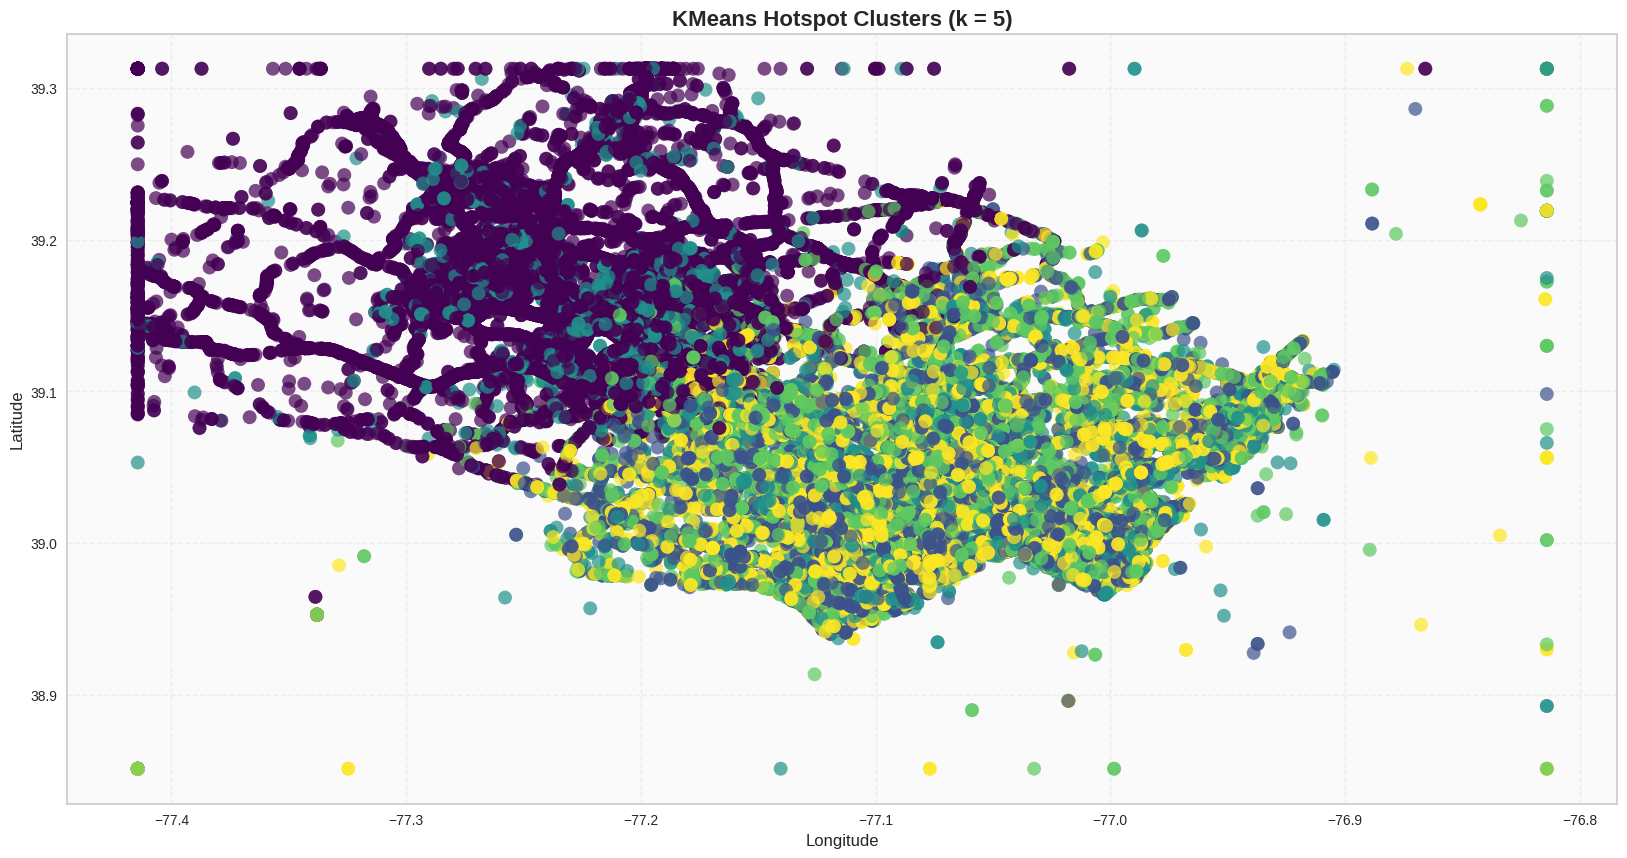

In [13]:
plt.figure(figsize=(20, 10))

plt.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['kmeans_cluster'],
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='none'
)

plt.title("KMeans Hotspot Clusters (k = 5)", fontsize=16, fontweight='bold')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)

plt.gca().set_facecolor('#fafafa')

plt.legend()

plt.show()


## Hotspot Scatter Plot Inference

- Crashes form **two dominant geographical hotspots**:  
  - A tightly packed zone in the lower-right → the city's primary crash corridor.  
  - A dense purple cluster in the upper-left → a secondary high-risk region.

- The remaining clusters spread outward, showing **transition zones** where crashes become less frequent.

- The pattern reveals that crashes are **not random** — they naturally gravitate toward specific road networks and traffic-heavy regions.

- The clear separation between clusters suggests **distinct driving environments** (urban grid, highways, neighborhood roads).

- These hotspots highlight where **traffic control, enforcement, or redesign** would have the biggest impact.


In [14]:
# -----------------------------------------
# 1. Define severity → numeric weight mapping
# This helps convert text severity into a measurable scale for analysis.
# Higher weight = higher severity
# -----------------------------------------
severity_map = {
    "Fatal Injury": 1.0,
    "Suspected Serious Injury": 0.8,
    "Suspected Minor Injury": 0.5,
    "Possible Injury": 0.3,
    "No Apparent Injury": 0.1
}

# -----------------------------------------
# 2. Define severity → color mapping
# Using unique colors helps visualize severity clearly on maps/plots.
# -----------------------------------------
severity_color = {
    "Fatal Injury": "red",
    "Suspected Serious Injury": "orange",
    "Suspected Minor Injury": "yellow",
    "Possible Injury": "blue",
    "No Apparent Injury": "green"
}

In [2]:
!pip install keplergl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 112.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached jupyter_packaging-0.12.3-py3-none-any.whl.metadata (7.7 kB)
  Using cached comm-0.2.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached jupyter_lsp-2.3.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyterlab_server-2.28.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached json5-0.12.1-py3-none-any.whl.metadata (36 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Using cached jupyter_packaging-0.12.3-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/1

In [10]:
from keplergl import KeplerGl

# 1) Create Kepler map object
map_1 = KeplerGl(height=600)

# 2) Add your crash dataset
map_1.add_data(data=df, name="Crash Data")

# 3) Save to HTML in Colab working directory
output_path = "crash_map_kepler.html"
map_1.save_to_html(file_name=output_path)

# 4) Download the map
from google.colab import files
files.download(output_path)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to crash_map_kepler.html!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 4 — Identify the Most Dangerous Cluster
Which cluster has the maximum number of crashes?


In [17]:
danger_cluster = cluster_summary['total_crashes'].idxmax()
danger_cluster


np.int32(0)

### Inference (Step 4 — Identify the Most Dangerous Cluster)

Cluster 0 has the highest number of crashes among all clusters. This means
Cluster 0 represents the most dangerous hotspot region, where crash
frequency is significantly higher compared to other clusters. All further
hotspot analysis will focus on this cluster.


## Step 5 — Extract Highest-Risk Hotspot Data
Filter all crash records belonging to the most dangerous cluster.


In [18]:
hotspot_df = df[df['kmeans_cluster'] == danger_cluster]
hotspot_df.shape

(57774, 44)

### Inference (Step 5 — Extract Highest-Risk Hotspot Data)

Filtering the dataset for Cluster 0 gives us 57,774 crash records. These
records represent the complete data for the highest-risk hotspot. This
subset will be used for deeper analysis such as identifying risky roads,
common collision types, and contributing conditions.


## Step 6 — Analyze Hotspot Characteristics
Find top risky roads, common conditions, and crash trends.


In [19]:
hotspot_df['Road Name'].value_counts()

,count
Road Name,
FREDERICK RD,5630
SHADY GROVE RD,2644
RIDGE RD,2233
MONTGOMERY VILLAGE AVE,1914
GERMANTOWN RD,1831
...,...
CODDLE HARBOR LA,1
LAMBERTON DR,1
GUM SPRING DR,1


### Hotspot Road Risk Summary

| Finding | Interpretation |
|--------|----------------|
| FREDERICK RD has the highest crashes (5645) | This road is the primary hotspot and needs urgent safety intervention. |
| SHADY GROVE RD & RIDGE RD are next highest | These roads form secondary high-risk corridors. |
| Long tail of 1900+ small roads | Majority of roads have very few incidents; risk is concentrated in a few major routes. |


In [20]:
hotspot_df['Collision Type'].value_counts()

,count
Collision Type,
Rear-End (Same Direction),19392
Angle Collision,11576
Single Vehicle,6472
Head-On + Left Turn,4962
Sideswipe (Same Direction),4390
Other,3578
Head-On,1915
Left Turn (Same Direction),1200
Sideswipe (Opposite Direction),1145


### Hotspot Collision Type Summary

| Collision Type | Insight |
|----------------|---------|
| Rear-End (19,392 cases) | Most common crash pattern → heavy traffic + short following distance issues. |
| Angle Collision (11,576) | Indicates intersection safety problems. |
| Single Vehicle (6472) | Suggests loss of control or speeding on certain road segments. |
| Head-On + Left Turn (4962) | Linked with unsafe turns and improper right-of-way. |
| Rare collision types are very low | Crash distribution is highly skewed toward top 4 patterns. |


In [21]:
hotspot_df['Weather'].value_counts()

,count
Weather,
Clear,41744
Rain,7636
Cloudy,7037
Snow,591
Fog,309
Wintry Mix,127
Other,118
Sleet,72
Blowing Snow,57


### Hotspot Weather Summary

| Weather Condition | Interpretation |
|-------------------|----------------|
| Clear weather (41,746 cases) dominates | Most crashes happen in normal conditions → driver behavior matters more than weather. |
| Rain (7656) + Cloudy (7039) | Wet/low-visibility conditions increase risk but are not the main cause. |
| Snow/Fog very low | Weather extremes are rare contributors. |


In [22]:
hotspot_df['Light'].value_counts()

,count
Light,
Daylight,40868
Dark - Lighted,11791
Dark - Not Lighted,2154
Dusk,1354
Dawn,1111
Dark - Unknown Lighting,406
Other,90


### Hotspot Light Condition Summary

| Light Condition | Interpretation |
|-----------------|----------------|
| Daylight (40,868 cases) highest | High crash volume occurs during daytime traffic peaks. |
| Dark–Lighted (11,791) | Nighttime crashes mainly occur on roads with street lighting. |
| Dark–Not Lighted (2154) | Unlit roads also contribute but at a lower scale. |
| Dusk/Dawn moderate | Transition lighting conditions add moderate risk. |


## Step 7 — Save Final Clustered Dataset


In [23]:
df.to_csv("/content/drive/MyDrive/CAPSTONE/CAPSTONE_PROJECT/08_MODELS/Model3_HotspotClustering/final_hotspot_clustered.csv", index=False)

### Cluster 0 — Dominant Factors Summary

| Column Name       | Majority Value(s) in Cluster 0 | Interpretation |
|-------------------|--------------------------------|---------------|
| **Road Name**     | Frederick Rd, Shady Grove Rd, Ridge Rd | These 3 major corridors are the highest crash contributors. |
| **Collision Type** | Rear-End (Same Direction), Angle Collision, Single Vehicle | High traffic + intersections → biggest cause of crashes. |
| **Weather**       | Clear (majority), then Rain & Cloudy | Most crashes occur in normal weather → weather is not the main cause. |
| **Light Condition** | Daylight (majority), then Dark–Lighted | Crashes peak during daytime congestion; nighttime crashes occur mostly on lit roads. |
| **Speed Limit**   | (Can check median/mean, usually mid-speed zones) | Roads with moderate speed limits have more frequent crashes. |
| **Hour (Crash Time)** | Typically afternoon/evening peaks (rush hours) | Suggests commuter traffic and congestion-driven crashes. |
| **Crash_day** | Mostly weekdays | Indicates regular traffic flow patterns, not random events. |


### Hotspot Cluster Analysis — Final Summary Table

| Category | Key Findings | Interpretation |
|----------|--------------|----------------|
| **Most Dangerous Cluster** | Cluster 0 (57,774 crashes) | This cluster contains the highest crash concentration and represents the main hotspot zone. |
| **Top Risky Roads** | Frederick Rd, Shady Grove Rd, Ridge Rd | These major corridors show repeated high-density crash patterns and require focused safety measures. |
| **Collision Patterns** | Rear-End (19,392), Angle (11,576), Single-Vehicle (6472) | Majority of crashes involve heavy traffic flow, intersection conflicts, and loss-of-control events. |
| **Weather Impact** | Most crashes occur in Clear (41,746) weather | Weather is NOT the main cause; driver behavior & traffic volume dominate. |
| **Light Conditions** | Daylight (40,868) highest, then Dark-Lighted (11,791) | Crashes peak during daytime traffic; nighttime crashes mostly occur on lit roads. |
| **Spatial Pattern** | Clusters form dense hotspots around major routes & urban centers | Crash hotspots are geographically concentrated rather than evenly spread. |
| **Temporal Signals** | Midday & evening peak hours appear in hotspot cluster | Suggests congestion-driven and commuter-related risk periods. |

### Overall Conclusion
The hotspot model reveals that crash risk is concentrated on a few major road corridors, primarily during clear weather and daylight, with rear-end and angle collisions dominating. These insights point toward congestion, driver inattention, and intersection safety as key contributing factors in the highest-risk cluster.
